In [1]:
from __future__ import print_function
import SimpleITK as sitk
import sys, time, os
import numpy as np
import nibabel as nib
import glob
from scipy.ndimage.interpolation import zoom
import shutil
from matplotlib import pyplot as plt
from scipy import ndimage,signal,misc
import cv2
import random
import os
import multiprocessing

## Utility functions
A number of utility callback functions for image display and for plotting the similarity metric during registration.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(20,16))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('ori image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('mprave image')
    plt.axis('off')
    
    plt.show()

In [3]:
# Convert DICOM to nifti 
def dicom2nifti(dicom_dir):
    print(f'\nProcess this case {dicom_dir}')
    acc = os.path.basename(dicom_dir)
    print(acc)
                            
    #Using ImageSeriesReader to read the series at one time
    series_reader = sitk.ImageSeriesReader()
    series_reader.LoadPrivateTagsOn()
    series_reader.MetaDataDictionaryArrayUpdateOn()
    series_UIDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(dicom_dir)
    print(series_UIDs)
    if not series_UIDs:
        print("ERROR: given directory \""+acc+"\" does not contain a DICOM series.")
        return
    for UID in series_UIDs:
        series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(dicom_dir, UID)
#         print(series_file_names)
        series_reader.SetFileNames(series_file_names)
        
        # Read the file's meta-information without reading bulk pixel data
        file_reader = sitk.ImageFileReader()
        file_reader.SetFileName(series_file_names[0])
        file_reader.ReadImageInformation()
        
        # Get the sorted file names, opens all files in the directory and reads the meta-information
        # without reading the bulk pixel data
#         SeriesDescription = file_reader.GetMetaData('0008|103e')
        SeriesNumber = file_reader.GetMetaData('0020|0011')
        print(f'Process this series "{SeriesNumber}" in the {acc}') #{SeriesDescription} 
        image3D = series_reader.Execute()
#         sitk.GetArrayFromImage(image3D)
        
        return image3D
    
def save_array_as_nifty_volume(data, filename, reference_name = None):
    """
    save a numpy array as nifty image
    inputs:
        data: a numpy array with shape [Depth, Height, Width]
        filename: the ouput file name
        reference_name: file name of the reference image of which affine and header are used
    outputs: None
    """
    img = sitk.GetImageFromArray(data)
    if(reference_name is not None):
        img_ref = sitk.ReadImage(reference_name)
        img.CopyInformation(img_ref)
    sitk.WriteImage(img, filename)

In [4]:
def rotateImage(img, angle, pivot=None):
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = ndimage.rotate(imgP, angle, reshape=False)
    
    return imgR[padY[0] : -padY[1], padX[0] : -padX[1]]

def synthetic_motion(img, angles, pivot=None):
    imgs=np.zeros(img.shape)
    for angle in angles:
        ro_img = rotateImage(img, angle, pivot)
        imgs += ro_img
        imgs += 0.2*noisy('speckle', ro_img)
        
    return imgs/(len(angles)*1.2)   

def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = image + gauss

        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col = image.shape
        gauss = np.random.randn(row,col)
        gauss = gauss.reshape(row,col)        
        noisy = image + image * gauss
        return noisy

## Read images

We first read the images, casting the pixel type to that required for registration (Float32 or Float64) and look at them.

In [5]:
#from dicom folder
dicom_dir_nm='/Users/bz957/Documents/GitHub/Motion_Correction/dataset/MP-RAVE/MP_RAVE_NO_MOTION'
dicom_dir='/Users/bz957/Documents/GitHub/Motion_Correction/dataset/MP-RAVE/MP_RAVE_LESSMOTION'
output_dir = '/Users/bz957/Documents/GitHub/Motion_Correction/dataset/MP-RAVE/Add_motion'

images_nm = dicom2nifti(dicom_dir_nm)
images_m = dicom2nifti(dicom_dir)


Process this case /Users/bz957/Documents/GitHub/Motion_Correction/dataset/MP-RAVE/MP_RAVE_NO_MOTION
MP_RAVE_NO_MOTION
('1.3.6.1.4.1.9590.100.1.2.115242328511687237624675119911251468069',)
Process this series "14" in the MP_RAVE_NO_MOTION

Process this case /Users/bz957/Documents/GitHub/Motion_Correction/dataset/MP-RAVE/MP_RAVE_LESSMOTION
MP_RAVE_LESSMOTION
('1.3.6.1.4.1.9590.100.1.2.115242328511687237624675119911251468069',)
Process this series "16" in the MP_RAVE_LESSMOTION


### Show original series

In [6]:
interact(display_images, 
         fixed_image_z=(0,images_nm.GetSize()[2]-1), moving_image_z=(0,images_m.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(images_nm)), moving_npa=fixed(sitk.GetArrayViewFromImage(images_m)));

interactive(children=(IntSlider(value=95, description='fixed_image_z', max=191), IntSlider(value=95, descripti…

## Show add motion series

In [7]:
images_add_m = sitk.GetArrayFromImage(images_nm)
print(images_add_m.shape)

for i in range(images_add_m.shape[0]):
    img_ori = images_add_m[i,:,:]
    #set pivot and rotation angles
    pivot = (img_ori.shape[1]//2,img_ori.shape[0]*3//5)
    angles = np.arange(-3, 3.1, 0.5)
    images_add_m[i,:,:] = synthetic_motion(img_ori, angles=angles, pivot=pivot)

(192, 256, 256)


In [8]:
#get nifti images from the modified 3d array
images_add_m = sitk.GetImageFromArray(images_add_m)

interact(display_images, 
         fixed_image_z=(0,images_nm.GetSize()[2]-1), moving_image_z=(0,images_add_m.GetSize()[2]-1), 
         fixed_npa = fixed(sitk.GetArrayViewFromImage(images_nm)), moving_npa=fixed(sitk.GetArrayViewFromImage(images_add_m)));

interactive(children=(IntSlider(value=95, description='fixed_image_z', max=191), IntSlider(value=95, descripti…

## Add motion to nifti files,  using multiple process

In [21]:
# from nifti files
inputs_dir = glob.glob('/Users/bz957/Documents/GitHub/Motion_Correction/dataset/rotation4/ds000102/*/*T1w.nii.gz')

In [22]:
def synthetic_motion_pool(args_list):
    input_nii, output_nii = args_list[0],args_list[1]
    print(f'Processing on case {input_nii}')
    images_nm = sitk.ReadImage(input_nii)
    images_nm = sitk.GetArrayFromImage(images_nm)
    images_add_m = np.zeros(images_nm.shape)
    
    #set pivot and angles with a range to make each nifti motion different
    pivot_paras = [np.random.uniform(0.4,0.6,1)[0], np.random.uniform(0.2,0.4,1)[0]]
    #randomly choose
#     angle_paras = [np.random.randint(2,4), random.choice(np.arange(0.4, 0.6, 0.1))]
    #set a fixed angles
    angle_paras = [3, random.choice(np.arange(0.4, 0.6, 0.1))]
    pivot = (int(round(images_nm.shape[2]*pivot_paras[0])),int(round(images_nm.shape[1]*pivot_paras[1])))
    angles = np.arange(-angle_paras[0], angle_paras[0]+0.1, angle_paras[1])
    
    for i in range(images_nm.shape[0]):
        ori_slice = images_nm[i,:,:]
        images_add_m[i,:,:] = synthetic_motion(ori_slice, angles=angles, pivot=pivot)
        
    save_array_as_nifty_volume(images_add_m,output_nii,input_nii)

In [23]:
#multiprocess for each Nifty files
pool = multiprocessing.Pool(8)
args_list = []
for file in inputs_dir:
    input_nii = file
    output_nii = file.replace('.nii.gz','_motion.nii.gz')
    args_list.append([input_nii, output_nii])
pool.map(synthetic_motion_pool, args_list)

Processing on case /Users/bz957/Documents/GitHub/Motion_Correction/dataset/rotation4/ds000102/sub-22/sub-22_anat_sub-22_T1w.nii.gz
Processing on case /Users/bz957/Documents/GitHub/Motion_Correction/dataset/rotation4/ds000102/sub-23/sub-23_anat_sub-23_T1w.nii.gz
Processing on case /Users/bz957/Documents/GitHub/Motion_Correction/dataset/rotation4/ds000102/sub-14/sub-14_anat_sub-14_T1w.nii.gz
Processing on case /Users/bz957/Documents/GitHub/Motion_Correction/dataset/rotation4/ds000102/sub-25/sub-25_anat_sub-25_T1w.nii.gz
Processing on case /Users/bz957/Documents/GitHub/Motion_Correction/dataset/rotation4/ds000102/sub-13/sub-13_anat_sub-13_T1w.nii.gz
Processing on case /Users/bz957/Documents/GitHub/Motion_Correction/dataset/rotation4/ds000102/sub-15/sub-15_anat_sub-15_T1w.nii.gz
Processing on case /Users/bz957/Documents/GitHub/Motion_Correction/dataset/rotation4/ds000102/sub-24/sub-24_anat_sub-24_T1w.nii.gz
Processing on case /Users/bz957/Documents/GitHub/Motion_Correction/dataset/rotation

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Test and save one img

In [200]:
img=images[100]
img_ori = images_nm[100]

In [201]:
pivot = (img_ori.shape[1]//2,img_ori.shape[0]*3//5)
angles = np.arange(-3, 3.1, 0.5)
dst = synthetic_motion(img_ori, angles=angles, pivot=pivot)
# dst = noisy('speckle', dst)
# dst = rotateImage(img, 5)

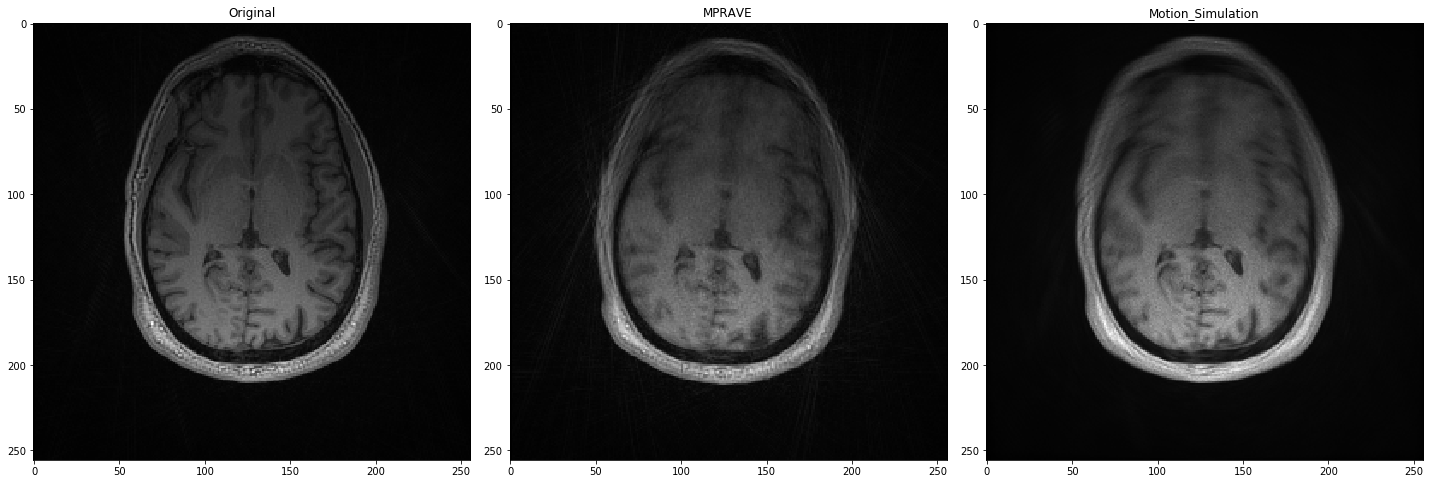

In [202]:
# kernel = np.ones((5,5),np.float32)/25
# dst = cv2.GaussianBlur(dst,(1,1),0)

fig1, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(20,20))

ax1.set_title('Original')
ax1.imshow(img_ori,cmap='gray')

ax2.set_title('MPRAVE')
ax2.imshow(img,cmap='gray')

ax3.set_title('Motion_Simulation')
ax3.imshow(dst,cmap='gray')

plt.tight_layout()
plt.show()

### Moconet, not finished

In [73]:
img=nifti_image[128]

In [74]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
# dst = np.abs(fshift)
k_space = 20*np.log(np.abs(fshift))

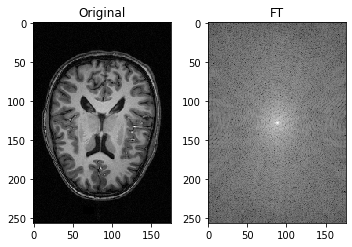

In [75]:
fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(5,10))
# fig2,  = plt.subplots(figsize=(5,10))

ax1.set_title('Original')
ax1.imshow(img,cmap='gray')

ax2.set_title('FT')
ax2.imshow(k_space,cmap='gray')

plt.tight_layout()
plt.show()

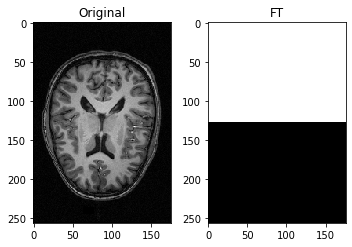

In [69]:
mask = np.zeros(img.shape)
mask[:img.shape[0]//2,:] = 1

fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(5,10))
# fig2,  = plt.subplots(figsize=(5,10))

ax1.set_title('Original')
ax1.imshow(img,cmap='gray')

ax2.set_title('FT')
ax2.imshow(mask,cmap='gray')

plt.tight_layout()
plt.show()

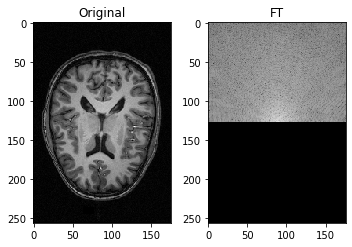

In [76]:
#partial k-space of the object
partial_k_img = mask*k_space

fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(5,10))
# fig2,  = plt.subplots(figsize=(5,10))

ax1.set_title('Original')
ax1.imshow(img,cmap='gray')

ax2.set_title('FT')
ax2.imshow(partial_k_img,cmap='gray')

plt.tight_layout()
plt.show()

/Users/bz957/VirtualEnvironments/deepneuro/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


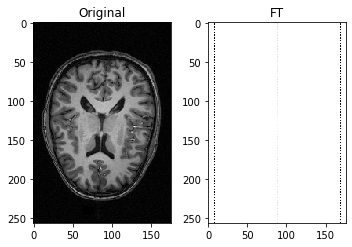

In [85]:
mask_f = np.fft.fft2(mask)
mask_fshift = np.fft.fftshift(mask_f)
# dst = np.abs(fshift)
mask_k = 20*np.log(np.abs(mask_fshift))

fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(5,10))
# fig2,  = plt.subplots(figsize=(5,10))

ax1.set_title('Original')
ax1.imshow(img,cmap='gray')

ax2.set_title('FT')
ax2.imshow(mask_k,cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
#2d conv
mask_f = np.fft.fft2(mask)
mask_fshift = np.fft.fftshift(mask_f)
# dst = np.abs(fshift)
mask_k = 20*np.log(np.abs(mask_fshift))

fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(5,10))
# fig2,  = plt.subplots(figsize=(5,10))

ax1.set_title('Original')
ax1.imshow(img,cmap='gray')

ax2.set_title('FT')
ax2.imshow(mask_k,cmap='gray')

plt.tight_layout()
plt.show()



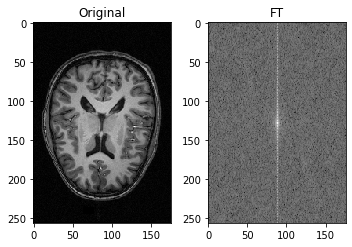

In [77]:
#partial FT
mask_f_b = np.fft.fft2(partial_k_img)
mask_fshift_b = np.fft.fftshift(mask_f_b)
# dst = np.abs(fshift)
partial_b = 20*np.log(np.abs(mask_fshift_b))

fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(5,10))
# fig2,  = plt.subplots(figsize=(5,10))

ax1.set_title('Original')
ax1.imshow(img,cmap='gray')

ax2.set_title('FT')
ax2.imshow(partial_b,cmap='gray')

plt.tight_layout()
plt.show()

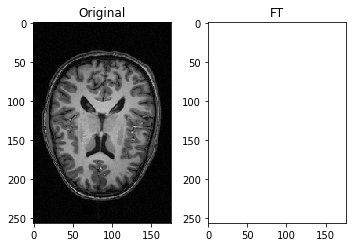

In [83]:
grad = signal.convolve2d(img, mask_k, boundary='symm', mode='same')

fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(5,10))
# fig2,  = plt.subplots(figsize=(5,10))

ax1.set_title('Original')
ax1.imshow(img,cmap='gray')

ax2.set_title('FT')
ax2.imshow(np.angle(grad),cmap='gray')

plt.tight_layout()
plt.show()



### Gaussian blur and save nifty

In [ ]:
nifti_dir = './dataset/ds000102/sub-01/sub-01_anat_sub-01_T1w.nii.gz'
# save_folder = '../data/langone/pre/nifti/watermarks'

# data_directory = '../data/langone/post/dicom_4series_acc'
# save_folder = '../data/langone/label/tolabel/post_0410'


# Load the nifti files
nifti_image = sitk.ReadImage(nifti_dir)
nifti_image = sitk.GetArrayFromImage(nifti_image)
# nifti_image = nifti_image.astype(np.uint8)
print(nifti_image.shape)

img=nifti_image
# img = normalize(img)

kernel = np.ones((5,5),np.float32)/25
dst = cv2.GaussianBlur(img,(5,5),0)

output_img = sitk.GetImageFromArray(dst)
save_array_as_nifty_volume(dst,'sub-01_anat_sub-01_T1w_GaussianBlur.nii.gz',nifti_dir)